# Example of FedAvg and FedProx for two datasets: MNIST iid and MNIST non-iid



In [ ]:
! curl -o create_MNIST_datasets.py "https://gitlab.inria.fr/ssilvari/flhd/-/raw/master/federated_learning/create_MNIST_datasets.py?inline=false"

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

## 1. MNIST iid

### Data loading and visualization

First of all, we load the train and test MNIST dataset and randomly split them in 3 non-overlapping datasets. We will use them for the 3 different nodes.

In [2]:
from create_MNIST_datasets import get_MNIST_iid
mnist_iid_train_dls, mnist_iid_test_dls = get_MNIST_iid(
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

In the following cell we plot some samples from the 3 datasets

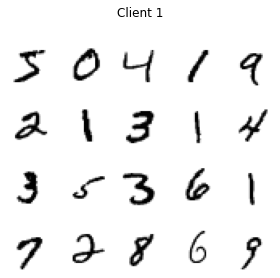

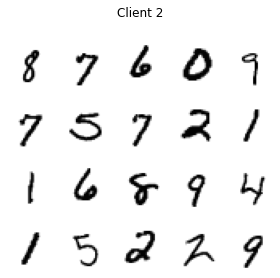

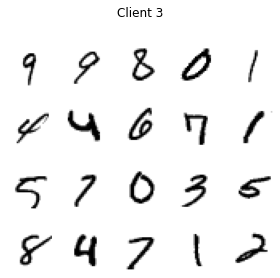

In [3]:
mnist_iid_train_dls[0].dataset.plot_samples(0, "Client 1")
mnist_iid_train_dls[1].dataset.plot_samples(0, "Client 2")
mnist_iid_train_dls[2].dataset.plot_samples(0, "Client 3")

As you can see, we have all the digit in all the clients. Indeed we split the dataset so to have independent and identically distributed (iid) samples.

### Classification

We define a convolutional neural network (CNN) for classification of digits. We also define the functions for training, computing the loss and accuracy.

In [4]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet -> 
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

model_0 = CNN()

In [5]:
def loss_classifier(predictions,labels):
    
    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")
    
    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0
    
    for idx,(features,labels) in enumerate(dataset):
        
        predictions= model(features)
        loss+=loss_f(predictions,labels)
    
    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""
    
    correct=0
    
    for features,labels in iter(dataset):
        
        predictions= model(features)
        
        _,predicted=predictions.max(1,keepdim=True)
        
        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()
        
    accuracy = 100*correct/len(dataset.dataset)
        
    return accuracy


def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""
    
    total_loss=0
    
    for idx, (features,labels) in enumerate(train_data):
        
        optimizer.zero_grad()
        
        predictions= model(features)
        
        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss
        
        loss.backward()
        optimizer.step()
        
    return total_loss/(idx+1)



def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    
    model_0=deepcopy(model)
    
    for e in range(epochs):
        local_loss=train_step(model,model_0,mu,optimizer,train_data,loss_f)
        
    return float(local_loss.detach().numpy())


def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) 
        for i in range(len(tensor_1))])
    
    return norm


def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)
        

### Aggregation strategies

In federated learning we have to define an aggregation strategy, ie a method to combine all the local models coming from the clients into a global one.

**Federated averaging**

The first and simplest aggregation strategy is federated averaging ([FedAvg](https://arxiv.org/pdf/1602.05629.pdf)).

The learning is performed in rounds. At each round, the server samples a set of $m$ clients (out of the total $K$ clients) which will be considered for this iteration and it sends them the current global model.
These clients updates the parameters of their local copy of the model, optimizing the loss $F_k$ on their local training data using SGD for $E$ epochs. At the end of the round, all the local parameters are sent to the server, which aggregates them by performing a weighted average. The aggregated parameters define the global model for the next round.

**FedProx**

Another strategy is [FedProx](https://arxiv.org/pdf/1812.06127.pdf), which is a generalization of FedAvg with some modifications to address heterogeneity of data and systems.

The learning is again performed in rounds. At each round, the server samples a set of $m$ clients and it sends them the current global model.
In contrast to FedAvg, here the clients optimize a regularized loss with a proximal term. In particular, the new function to minimize is $F_k(\omega) + \frac{\mu}{2}||\omega - \omega^t ||^2$, where $F_k$ is the loss, $\omega$ are the local parameter to optimize for and $\omega^t$ are the global parameter at time $t$.   
Moreover we run the local optimization for a variable number of epochs according to the system resources (so that also slow clients can contribute to the training with a reduced number of epochs). 
Again identically to FedAvg, the local parameters are sent to the server and aggregated.

**NOTE** FedAvg is a particular case of FedProx with $\mu=0$. So, we implemented the code for FedProx, which we will reuse also for FedAvg by setting the parameter *mu=0*

In [6]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""
    
    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    return new_model

In [7]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0, 
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the 
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration
    
    returns :
        - `model`: the final global model 
    """
        
    loss_f=loss_classifier
    
    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)
    
    
    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach()) 
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy() 
        for tens_param in list(model.parameters())]]
    models_hist = []
    
    
    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')
    
    for i in range(n_iter):
        
        clients_params=[]
        clients_models=[]
        clients_losses=[]
        
        for k in range(K):
            
            local_model=deepcopy(model)
            local_optimizer=optim.SGD(local_model.parameters(),lr=lr)
            
            local_loss=local_learning(local_model,mu,local_optimizer,
                training_sets[k],epochs,loss_f)
            
            clients_losses.append(local_loss)
                
            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)    
            clients_models.append(deepcopy(local_model))
        
        
        #CREATE THE NEW GLOBAL MODEL
        model = average_models(deepcopy(model), clients_params, 
            weights=weights)
        models_hist.append(clients_models)
        
        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach()) 
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')
        

        server_hist.append([tens_param.detach().cpu().numpy() 
            for tens_param in list(model.parameters())])
        
        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay
            
    return model, loss_hist, acc_hist

### Federated training with FedAvg

We will now train the model on the 3 clients, using FedAvg aggregation strategy.

**NOTE** In this notebook, during the training, we will consider all the 3 clients in every round ($m=K=3$)

In [8]:
# Train with FedAvg -> FedProx with mu=0

n_iter=10

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx( model_0, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, epochs =3, 
    lr =0.1, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3026487827301025 Server Test Accuracy: 6.0
====> i: 1 Loss: 2.0403614044189453 Server Test Accuracy: 56.0
====> i: 2 Loss: 0.9044532378514607 Server Test Accuracy: 67.0
====> i: 3 Loss: 0.6221261421839396 Server Test Accuracy: 74.66666666666666
====> i: 4 Loss: 0.2780721187591553 Server Test Accuracy: 84.66666666666666
====> i: 5 Loss: 0.13878133396307626 Server Test Accuracy: 90.0
====> i: 6 Loss: 0.09306075672308603 Server Test Accuracy: 91.0
====> i: 7 Loss: 0.06332090869545937 Server Test Accuracy: 90.33333333333333
====> i: 8 Loss: 0.04245084896683693 Server Test Accuracy: 90.66666666666666
====> i: 9 Loss: 0.031204679359992344 Server Test Accuracy: 90.0
====> i: 10 Loss: 0.02209764036039511 Server Test Accuracy: 90.33333333333333


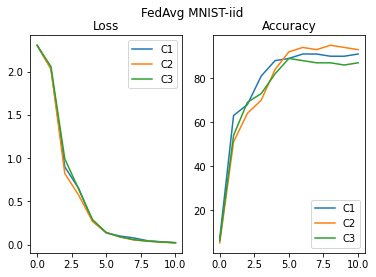

In [9]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    plt.figure()
    
    plt.suptitle(title)

    plt.subplot(1,2,1)
    lines=plt.plot(loss_hist)
    plt.title("Loss")
    plt.legend(lines,["C1", "C2", "C3"])

    plt.subplot(1,2,2)
    lines=plt.plot(acc_hist )
    plt.title("Accuracy")
    plt.legend(lines, ["C1", "C2", "C3"])
    

plot_acc_loss("FedAvg MNIST-iid", loss_hist_FA_iid, acc_hist_FA_iid)

### Federated training with FedProx

We will now train the model on the 3 clients, using FedProx aggregation strategy.

**NOTE** In this notebook, during the training, we will consider all the 3 clients in every round ($m=K=3$) and we assume they all have the same system resources (they will run the same number of epochs each round)

In [10]:
# Train with FedProx, mu=1

n_iter=10

model_f, loss_hist_FP_iid, acc_hist_FP_iid = FedProx( model_0, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, 
    epochs =3, lr =0.1, mu =1.)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.302648862202962 Server Test Accuracy: 6.0
====> i: 1 Loss: 2.256343364715576 Server Test Accuracy: 49.33333333333333
====> i: 2 Loss: 1.960483193397522 Server Test Accuracy: 42.666666666666664
====> i: 3 Loss: 1.4760499000549316 Server Test Accuracy: 53.99999999999999
====> i: 4 Loss: 0.8978065252304077 Server Test Accuracy: 67.0
====> i: 5 Loss: 0.7698407967885335 Server Test Accuracy: 71.0
====> i: 6 Loss: 0.4063149690628052 Server Test Accuracy: 84.33333333333333
====> i: 7 Loss: 0.3871262570222218 Server Test Accuracy: 86.33333333333333
====> i: 8 Loss: 0.34678515791893005 Server Test Accuracy: 84.33333333333333
====> i: 9 Loss: 0.20760734379291534 Server Test Accuracy: 88.0
====> i: 10 Loss: 0.19162407517433167 Server Test Accuracy: 88.33333333333333


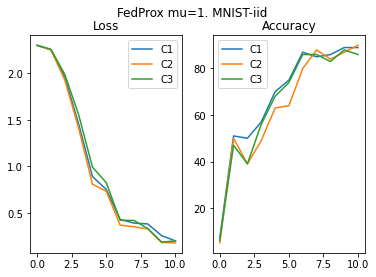

In [11]:
plot_acc_loss("FedProx mu=1. MNIST-iid", loss_hist_FP_iid, acc_hist_FP_iid)

### Conclusion and comparison

We can notice that with both aggregation strategies the model converges to a high value of accuracy (consider we are working with 600 images only). In this case where we have iid dataset across clients, the accuracy of FedAvg and FedProx are comparable.

## 2. MNIST non-iid

We create a dataset of noisy digits and split it using a non-iid sampling. We assign digits 012, 345, 678 to the 3 different clients.

In [12]:
C= {
     'n_samples_train': 200,
     'font':'InconsolataN',
     'tilt': [0, 45, 90],
     'std_tilt': 10, #std on the tilt,
     'seed':0
     }
C['n_samples']= int(1.5 * C['n_samples_train']) #20% more for the testing set

C1 =deepcopy(C)
C1['numbers'] = [1, 2, 3]

C2=deepcopy(C)
C2['numbers'] = [4, 5, 6]

C3=deepcopy(C)
C3['numbers']= [7, 8, 9]

clients = [C1, C2, C3]

In [13]:
from create_MNIST_datasets import get_MNIST_niid
custom_mnist_train, custom_mnist_test = get_MNIST_niid(
    clients, batch_size =10)

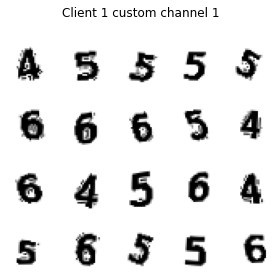

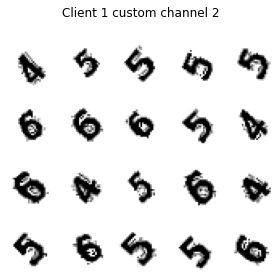

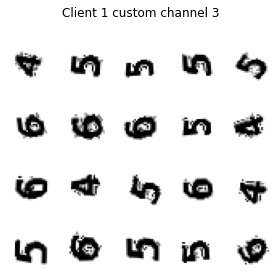

In [14]:
custom_mnist_train[1].dataset.plot_samples(0, "Client 1 custom channel 1")
custom_mnist_train[1].dataset.plot_samples(1, "Client 1 custom channel 2")
custom_mnist_train[1].dataset.plot_samples(2, "Client 1 custom channel 3")

### Federated training with FedAvg

In [15]:
n_iter=15

model_f, loss_hist_FA_niid, acc_hist_FA_niid = FedProx( model_0, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=3, lr=0.1, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.2996485233306885 Server Test Accuracy: 10.333333333333332
====> i: 1 Loss: 2.1265652179718018 Server Test Accuracy: 40.0
====> i: 2 Loss: 1.5005696614583333 Server Test Accuracy: 50.0
====> i: 3 Loss: 0.8817243576049804 Server Test Accuracy: 68.33333333333333
====> i: 4 Loss: 0.7961297035217285 Server Test Accuracy: 73.0
====> i: 5 Loss: 0.47359542051951087 Server Test Accuracy: 80.0
====> i: 6 Loss: 0.5291634003321329 Server Test Accuracy: 75.66666666666666
====> i: 7 Loss: 0.3741661409536997 Server Test Accuracy: 82.33333333333333
====> i: 8 Loss: 0.7093196461598077 Server Test Accuracy: 67.66666666666666
====> i: 9 Loss: 0.8421186978618304 Server Test Accuracy: 65.33333333333333
====> i: 10 Loss: 0.7133570685982704 Server Test Accuracy: 65.66666666666666
====> i: 11 Loss: 1.4599915978809197 Server Test Accuracy: 55.33333333333333
====> i: 12 Loss: 0.6197358941038449 Server Test Accuracy

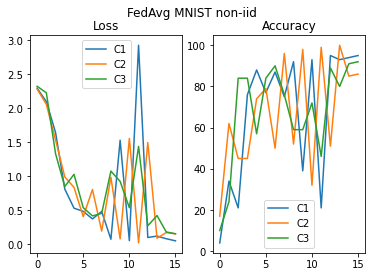

In [16]:
plot_acc_loss("FedAvg MNIST non-iid", loss_hist_FA_niid, acc_hist_FA_niid)

### Federated training with FedProx

In [17]:
n_iter=15

model_f, loss_hist_FP_niid, acc_hist_FP_niid = FedProx( model_0, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=3, lr=0.1, mu=.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.2996485233306885 Server Test Accuracy: 10.333333333333332
====> i: 1 Loss: 2.1950867970784502 Server Test Accuracy: 23.0
====> i: 2 Loss: 1.8597861528396606 Server Test Accuracy: 30.0
====> i: 3 Loss: 1.4968410730361938 Server Test Accuracy: 39.0
====> i: 4 Loss: 1.1217716534932454 Server Test Accuracy: 54.33333333333333
====> i: 5 Loss: 1.190993030865987 Server Test Accuracy: 54.33333333333333
====> i: 6 Loss: 0.8669322927792866 Server Test Accuracy: 66.66666666666666
====> i: 7 Loss: 0.714597225189209 Server Test Accuracy: 70.66666666666666
====> i: 8 Loss: 0.6316446661949158 Server Test Accuracy: 73.66666666666666
====> i: 9 Loss: 0.5291367868582407 Server Test Accuracy: 75.0
====> i: 10 Loss: 0.4781126379966736 Server Test Accuracy: 78.0
====> i: 11 Loss: 0.4492119451363881 Server Test Accuracy: 76.0
====> i: 12 Loss: 0.3932275573412577 Server Test Accuracy: 79.33333333333333
====> i: 

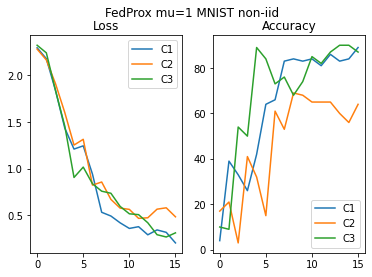

In [18]:
plot_acc_loss("FedProx mu=1 MNIST non-iid", loss_hist_FP_niid, acc_hist_FP_niid)

### Conclusion and comparison

Also in the non-iid case both aggregation methods yields good results in term of accuracy. FedProx is performing slighly better, since it is able to compensate for the heterogeneity of the data across the different clients